<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

3. (дополнительно)  Попробуйте не делать One-Hot-Encoding для категориальных переменных, а добавить их обработку в свой алгоритм. Сравните качество работы алгоритма с предыдущим решением.

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [3]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
df.drop('Survived', axis=1, inplace=True)

In [4]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

In [6]:
type(y)

pandas.core.series.Series

## Разделение на train, test

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [8]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


In [9]:
X_train

,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
299,50.0,247.5208,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
647,56.0,35.5000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
476,34.0,21.0000,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
390,36.0,120.0000,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1
473,23.0,13.7917,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,21.0,262.3750,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
528,39.0,7.9250,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
74,32.0,56.4958,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
176,28.0,25.4667,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1


Чтобы модель могла обучаться, мы каким-то образом должны передавать её y_train. Мы можем сделать это, просто добавив столбец с y_train в X_train:

In [10]:
full_train = X_train.copy()
full_train['Survived'] = y_train

## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [13]:
import math as m

In [14]:
d = {'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс

In [28]:
def get_target(df):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1
        
        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """
    # YOUR CODE HERE
    return df['Survived'].mode()[0]


def get_entropy(target):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)
        
        Output - значение энтропии (тип - float)
    """
    # YOUR CODE HERE
    #Случай полной определенности
    if (target.value_counts().count() == 1):
        entropy = 1
    #Случай разделения
    else:
        N1 = target.value_counts()[0]
        N2 = target.value_counts()[1]
        N = N1 + N2
        entropy = -((N1/N)*m.log2(N1/N) + (N2/N)*m.log2(N2/N))
    return entropy



def feature_separation(df, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target), 
                f_name: название фичи (для которой ищем разбиение)
                
        Output - прирост энтропии, порог разбиения
    """
    
    # YOUR CODE HERE
    #Возьмем все уникальные значения для feature и сортируем их
    feature = np.sort(df[f_name].unique())
    entropy_target = get_entropy(df['Survived'])
    rows = len(feature)
    
    delta_entropy = 0
    threshold = 0
    #Все возможные трешхолды как средние значения между соседними элементами
    thresh_list = []
    for i in range(rows-1):
        thresh_list.append((feature[i] + feature[i+1])/2)
    #Находим наибольшее значение дельты энтропии
    for thresh in thresh_list:
        left = df[df[f_name] < thresh]
        right = df[df[f_name] > thresh]
        S1 = get_entropy(left['Survived'])
        S2 = get_entropy(right['Survived'])
        N1 = len(left)/len(df)
        N2 = len(right)/len(df)
        this_delta_entropy = entropy_target - (N1*S1 + N2*S2)
        if (this_delta_entropy > delta_entropy):
            delta_entropy = this_delta_entropy
            threshold = thresh
        
    return (delta_entropy, threshold)


def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    delta_entropy = 0
    sep_feature, threshold, groups = None, None, df
    all_features = [c for c in df.columns.tolist() if c != 'Survived']

    for f in all_features:
        # YOUR CODE HERE
        this_delta_entropy, thresh = feature_separation(df, f)
        if (this_delta_entropy > delta_entropy):
            delta_entropy = this_delta_entropy
            threshold = thresh
            sep_feature = f
        #return None
    groups = (df[df[sep_feature] < threshold], df[df[sep_feature] > threshold])
    return {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}


def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    
    df_left, df_right = node['groups']
    sep_feature = node['feature_name']
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    #Если выполняется, то находим таргет из одной из них
    #Чтобы не проверять, какое дерево именно пустое, соединим их
    if len(df_left) == 0 or len(df_right) == 0:
        node['left'] = node['right'] = get_target(pd.concat([df_right, df_left]))
        return
    
    # проверяем максимальную глубину
    if depth >= max_depth:
        node['left'], node['right'] = get_target(df_left), get_target(df_right)
        return
    
    else:
        node['left'] = best_separation(df_left)
        split(node['left'], max_depth, depth + 1)

        node['right'] = best_separation(df_right)
        split(node['right'], max_depth, depth + 1)
        
        
def fit_my_tree(df, max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """    
    root = best_separation(df)
    split(root, max_depth, 1)

    return root

In [29]:
my_tree = fit_my_tree(full_train, 3)

## Predict MyDecisionTree  

In [30]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """    
    if row[tree['feature_name']] <= tree['threshold']:
        if type(tree['left']) == dict:
            return predict_raw(row, tree['left'])
        else:
            return tree['left']
    else:
        if type(tree['right']) == dict:
            return predict_raw(row, tree['right'])
        else:
            return tree['right']
    
    
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, my_tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [32]:
my_pred_test = predict_my_tree(X_test, my_tree)
my_pred_train = predict_my_tree(X_train, my_tree)

<ipython-input-30-502e52ba210a>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predict = pd.Series()


## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [38]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [39]:
clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=0)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

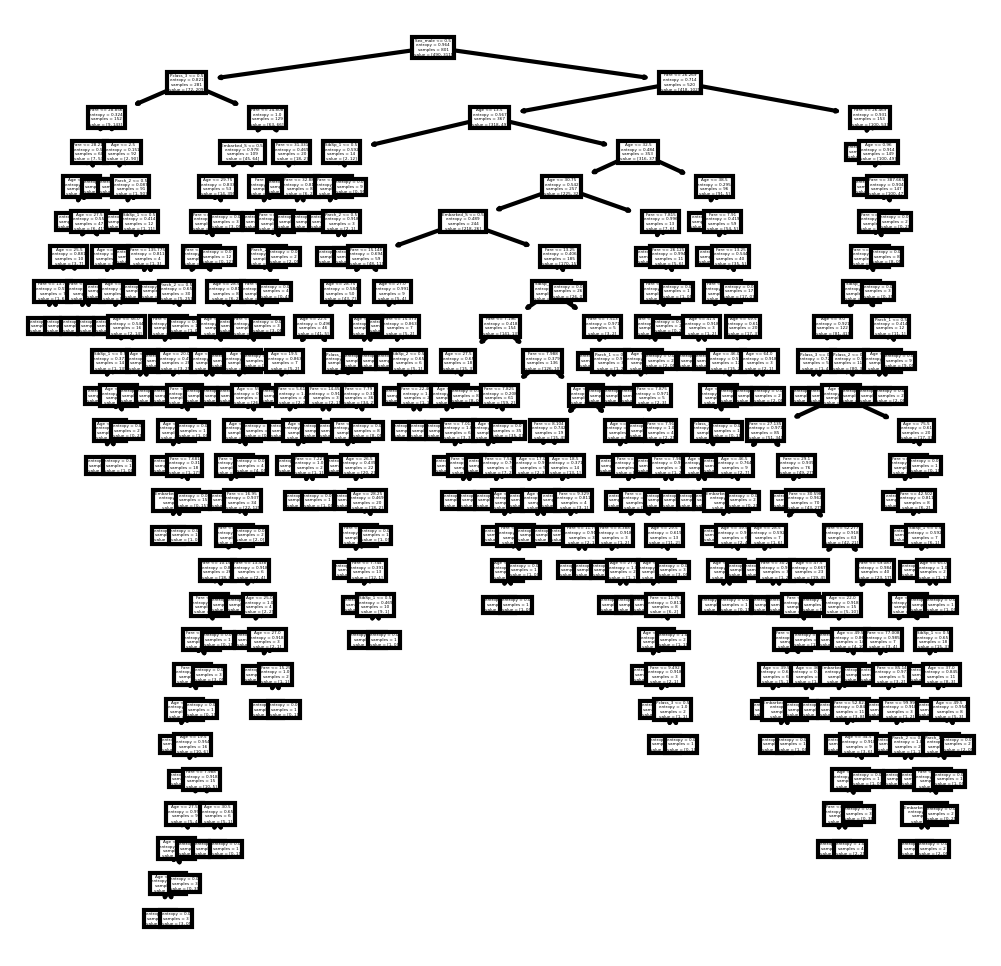

In [40]:
#Отрисовать дерево можно вот так:   
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
plot_tree(clf_tree, feature_names = X_train.columns);

## Сравнение метрик

In [41]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [42]:
assert abs(my_roc_test - 0.6) >= 0.2

Сравним результаты по roc-auc:

In [43]:
print("Sklearn Tree: ", skl_roc_test)
print("My Tree: ", my_roc_test)

Sklearn Tree:  0.8261344997266267
My Tree:  0.8523783488244943


Видим, что результат нашего дерева даже лучше при той же глубине, чем у Sklearn.